In [2]:
import pandas as pd
pd.options.display.float_format = '{:,.1f}'.format

In [3]:
%matplotlib inline

## Merging model accuracy data and MTurk jugments data

In [156]:
model_df = pd.read_csv("/private/home/gulordava/colorlessgreen/data/results/Italian/best_model.tab",sep="\t")

In [157]:
mturk_data = pd.read_csv("/private/home/gulordava/colorlessgreen/data/mturk_experiment/paper.tab",sep="\t")

In [158]:
mturk_data.columns

Index(['worker_id', 'type', 'class', 'answer', 'correct_answer', 'opt1',
       'opt2', 'full_id', 'sent', 'batch', 'pattern_id', 'constr_id',
       'sent_id', 'pattern'],
      dtype='object')

In [159]:
mturk_data["class"] = ["correct" if x == "T" else "wrong" for x in mturk_data["class"]]
mturk_data = mturk_data.drop("pattern_id",1)

In [160]:
counts = mturk_data.groupby(["pattern","constr_id","sent_id","class","type"]).size().reset_index(name="mturk_count")

In [161]:
merged = model_df.merge(counts, on=["pattern","constr_id","sent_id","class","type"],how="left")
merged.mturk_count = merged.mturk_count.fillna(0)

#merged.to_csv("/private/home/gulordava/colorlessgreen/data/results/Italian_all_models.tab",sep="\t",index=False)
#merged[fields + ["mturk_count","hidden650_batch64_dropout0.2_lr10.0"]].to_csv("/private/home/gulordava/colorlessgreen/data/results/best_model_mturk.tab",sep="\t",index=False)

In [162]:
merged[:2]

,pattern,constr_id,sent_id,correct_number,form,class,type,prefix,n_attr,punct,freq,len_context,len_prefix,sent,full_id,hidden650_batch64_dropout0.2_lr20.0,mturk_count
0,L__DET_ADJ_NOUN,30,6,sing,faro,correct,generated,Il divario potrà essere gradito persino con il...,0,False,430,4,11,Il divario potrà essere gradito persino con il...,L!DET_ADJ_NOUN!Number=Sing!Number=Plur__30__6,-8.6,8.0
1,L__DET_ADJ_NOUN,30,6,sing,fari,wrong,generated,Il divario potrà essere gradito persino con il...,0,False,644,4,11,Il divario potrà essere gradito persino con il...,L!DET_ADJ_NOUN!Number=Sing!Number=Plur__30__6,-14.2,0.0


## Analysing data

In [163]:
#full_df = pd.read_csv("/private/home/gulordava/colorlessgreen/data/results/best_model_mturk.tab", sep="\t")

In [168]:
models = [s for s in model_df.columns if "hidden" in s] + ["mturk_count","freq"]
fields = ["pattern","constr_id","sent_id","type","prefix","correct_number","n_attr","punct","len_context","len_prefix"]

In [169]:
wide_data = merged[fields +  ["class",] + models].pivot_table(columns=("class"),values=(models),index=fields)
for model in models:
    correct = wide_data.loc[:, (model, "correct")]
    wrong = wide_data.loc[:, (model, "wrong")]
    if model != "mturk_count":        
        wide_data[(model, "acc")] = pd.to_numeric(correct > wrong) * 100
    else:
        wide_data[(model, "acc")] = pd.to_numeric(correct / (wrong + correct)) * 100
wide_data.groupby("type").agg({(m,"acc"):"mean" for m in models})

,hidden650_batch64_dropout0.2_lr20.0,mturk_count,freq
,acc,acc,acc
type,,,
generated,84.8,88.4,54.1
original,90.8,94.5,54.6


In [170]:
wide_data.groupby("pattern").size()

pattern
L__DET_ADJ_NOUN                140
L__NOUN_VERB_PRON_VERB          60
L__NOUN_VERB_VERB              270
R__ADJ_ADJ_CCONJ_ADJ           130
R__NOUN_ADJ_PUNCT_PRON_VERB    100
R__NOUN_NOUN_ADV_ADJ           130
R__NOUN_NOUN_VERB              180
R__VERB_NOUN_CCONJ_VERB        180
dtype: int64

Overall accuracy per pattern

In [171]:
t = wide_data.reset_index()
t = t[[(f,"") for f in fields] + [(m, "acc") for m in models]]
t.columns = t.columns.droplevel(level=1)
#t.to_csv("/private/home/gulordava/colorlessgreen/data/results/Italian_accuracies.tab",sep="\t",index=False)

In [172]:
#t = wide_data.reset_index()
a = pd.concat([#[t.groupby("pattern").agg({m:"mean" for m in ms}), 
           t[t.type=="original"].groupby("pattern").agg({m: "mean" for m in models}).rename(columns={'acc': 'orig'}),
           t[t.type=="generated"].groupby("pattern").agg({m: "mean" for m in models}).rename(columns={'acc': 'gen'})],
          axis=1)
#a.index = ms
#a = a.reset_index()
#a.columns = ["pattern"] + ["acc_original_" + m for m in ms] + ["acc_generated_" + m for m in ms]
a

,hidden650_batch64_dropout0.2_lr20.0,mturk_count,freq,hidden650_batch64_dropout0.2_lr20.0,mturk_count,freq
pattern,,,,,,
L__DET_ADJ_NOUN,100.0,98.7,50.0,92.1,98.1,48.4
L__NOUN_VERB_PRON_VERB,100.0,93.1,66.7,98.1,95.4,64.8
L__NOUN_VERB_VERB,92.6,97.0,44.4,92.2,92.3,47.3
R__ADJ_ADJ_CCONJ_ADJ,100.0,98.5,69.2,98.3,98.0,66.7
R__NOUN_ADJ_PUNCT_PRON_VERB,90.0,95.9,30.0,84.4,89.5,31.1
R__NOUN_NOUN_ADV_ADJ,92.3,91.5,53.8,77.8,79.4,55.6
R__NOUN_NOUN_VERB,72.2,87.1,55.6,65.4,73.4,54.9
R__VERB_NOUN_CCONJ_VERB,88.9,94.0,72.2,78.4,86.8,66.7


### Correlation of Mturk vs LM

In [173]:
#a = pd.read_csv("/private/home/gulordava/colorlessgreen/data/results/Italian_accuracies.tab",sep="\t")

In [174]:
from scipy.stats import pearsonr
t[models].corr()*100

,hidden650_batch64_dropout0.2_lr20.0,mturk_count,freq
hidden650_batch64_dropout0.2_lr20.0,100.0,46.1,8.7
mturk_count,46.1,100.0,1.5
freq,8.7,1.5,100.0


## Some plotting

In [175]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [176]:
%%R
library(data.table)
library(ggplot2)
library(mgcv)

In [177]:
%Rpush t

In [178]:
t[t.sent_id == 0].groupby("n_attr").size()

n_attr
0    85
1    23
2    10
3     1
dtype: int64

In [179]:
%%R
levels(t$type)
t$type <- factor(t$type, levels = c("original", "generated"))
#t[t$type == "generated",]$type <- "nonce"
levels(t$type)[levels(t$type)=="generated"] <- "nonce"

    n_attr     type     SE_LM SE_people variable    value         SE
 1:      0 original  2.013302 0.6947785   people 96.21458  0.6947785
 2:      0    nonce  1.049786 0.5134632   people 92.45633  0.5134632
 3:      1 original  8.081047 1.8496259   people 93.31388  1.8496259
 4:      1    nonce  3.095127 1.3068303   people 82.29751  1.3068303
 5:      2 original 15.275252 9.9632013   people 85.15152  9.9632013
 6:      2    nonce  4.996878 3.5217192   people 70.00233  3.5217192
 7:      0 original  2.013302 0.6947785       LM 96.47059  2.0133023
 8:      0    nonce  1.049786 0.5134632       LM 90.71895  1.0497860
 9:      1 original  8.081047 1.8496259       LM 82.60870  8.0810468
10:      1    nonce  3.095127 1.3068303       LM 72.94686  3.0951274
11:      2 original 15.275252 9.9632013       LM 70.00000 15.2752523
12:      2    nonce  4.996878 3.5217192       LM 66.66667  4.9968779


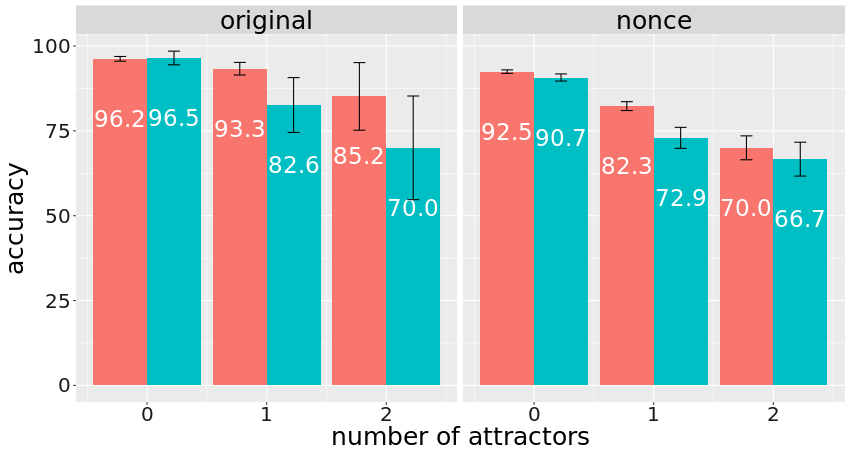

In [185]:
%%R -w 850 -h 450

best = "hidden650_batch64_dropout0.2_lr20.0"
dt = data.table(t)

#dt = dt[sent_id != 0]
x= dt[,.(mean(get(best)),mean(mturk_count),sd(get(best))/sqrt(.N),sd(mturk_count)/sqrt(.N)),by=.(n_attr,type)]
#print(x)
colnames(x) = c("n_attr","type","LM","people","SE_LM","SE_people")

m = melt(x[n_attr < 3], idvars=c("n_attr"), measure.vars=c("people","LM"))
m$SE <- 0.0
m[variable == "people"]$SE <- m[variable == "people"]$SE_people
m[variable == "LM"]$SE <- m[variable == "LM"]$SE_LM
#m = melt(m, idvars=c("n_attr","variable"), measure.vars=c("SE_people","SE_LM"))
print(m)

pd <- position_dodge(.9) 
text = element_text(size=25, color="black")
p = ggplot(m, aes(x=n_attr,y=value,fill=variable)) + geom_bar(stat="identity",position=pd) + facet_wrap(~type)
p = p + xlab("number of attractors") + ylab("accuracy") + labs(fill="") + guides(fill=FALSE)
p = p + geom_text(aes(label=format(value, digits=3)), vjust=4, colour="white", position=pd, size=8) 
p = p + geom_errorbar(aes(ymin=value-SE, ymax=value+SE), width=.2,position=pd) + scale_fill_discrete(labels=c("subjs","LSTM"))
p + theme(axis.title.x=text, axis.title.y=text, legend.text=text, axis.text.x=element_text(size=20, color="grey10"), 
          axis.text.y=element_text(size=20,color="grey10"), strip.text=text)

/private/home/gulordava/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `geom_smooth()` using method = 'gam'

  warnings.warn(x, RRuntimeWarning)


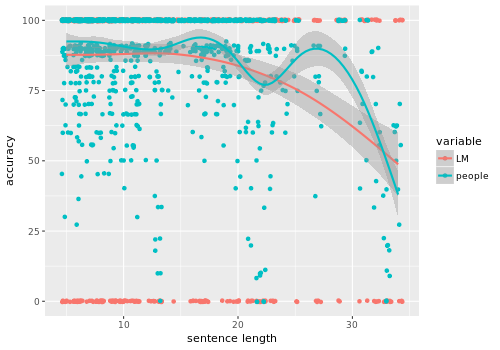

In [186]:
%%R -w 500 -h 350

dt = data.table(t)
#dt = dt[sent_id != 0]
#x= dt[,.(mean(hidden650_batch64_dropout0.2_lr10.0),mean(mturk_acc)),by=len_prefix]
#colnames(x) = c("len_prefix","LM","people")

m = melt(dt, idvars=c("len_prefix"), measure.vars=c(best,"mturk_count"))

p = ggplot(m, aes(x=len_prefix,y=value,color=variable)) + geom_point(position="jitter") + geom_smooth()
p = p + xlab("sentence length") + ylab("accuracy") + labs(fill="Population") +  scale_color_discrete(labels=c("LM","people"))
p # + geom_text(aes(label=format(value*100, digits=3)), vjust=3, colour="white", position=position_dodge(.9), size=4.5) 

/private/home/gulordava/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `geom_smooth()` using method = 'loess'

  warnings.warn(x, RRuntimeWarning)


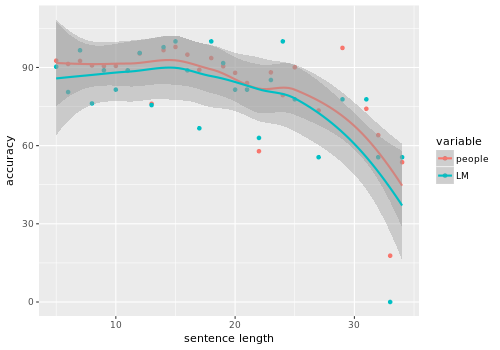

In [187]:
%%R -w 500 -h 350

dt = data.table(t)
dt = dt[sent_id != 0]
x= dt[,.(mean(get(best)),mean(mturk_count)),by=len_prefix]
colnames(x) = c("len_prefix","LM","people")

m = melt(x, idvars=c("len_prefix"), measure.vars=c("people","LM"))

p = ggplot(m, aes(x=len_prefix,y=value,color=variable)) + geom_point() + geom_smooth()
p = p + xlab("sentence length") + ylab("accuracy") + labs(fill="Population")
p # + geom_text(aes(label=format(value*100, digits=3)), vjust=3, colour="white", position=position_dodge(.9), size=4.5) 

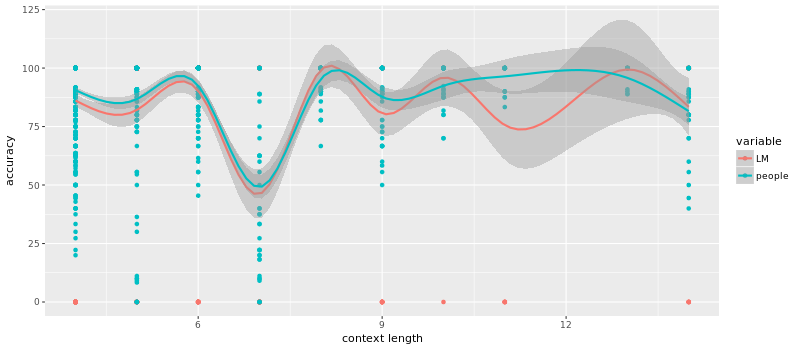

In [188]:
%%R -w 800 -h 350

dt = data.table(t)
#dt = dt[sent_id != 0]

m = melt(dt, idvars=c("len_context"), measure.vars=c(best,"mturk_count"))

p = ggplot(m, aes(x=len_context,y=value,color=variable)) + geom_point() + geom_smooth() #+ facet_wrap(~pattern,ncol=4)
p = p + xlab("context length") + ylab("accuracy") + labs(fill="Population") +  scale_color_discrete(labels=c("LM","people"))
p # + geom_text(aes(label=format(value*100, digits=3)), vjust=3, colour="white", position=position_dodge(.9), size=4.5) 

    punct                     pattern        LM   people     se_lm se_people
 1:  TRUE             L__DET_ADJ_NOUN  87.50000 97.29942  5.295741 0.7574122
 2: FALSE             L__DET_ADJ_NOUN  95.00000 98.51623  2.190429 0.4005463
 3: FALSE      L__NOUN_VERB_PRON_VERB  98.33333 95.17971  1.666667 0.9531988
 4: FALSE           L__NOUN_VERB_VERB  92.22222 92.75650  1.632937 0.7176199
 5:  TRUE        R__ADJ_ADJ_CCONJ_ADJ  98.33333 97.96444  1.173549 0.4044629
 6: FALSE        R__ADJ_ADJ_CCONJ_ADJ 100.00000 99.09091  0.000000 0.9090909
 7:  TRUE R__NOUN_ADJ_PUNCT_PRON_VERB  85.00000 90.12781  3.588703 1.4381273
 8: FALSE        R__NOUN_NOUN_ADV_ADJ  79.23077 80.57290  3.571596 1.7448665
 9: FALSE           R__NOUN_NOUN_VERB  68.23529 75.02547  3.581241 2.1810431
10:  TRUE           R__NOUN_NOUN_VERB  30.00000 69.91162 15.275252 3.3813902
11: FALSE     R__VERB_NOUN_CCONJ_VERB  79.44444 87.52217  3.020438 1.4849953


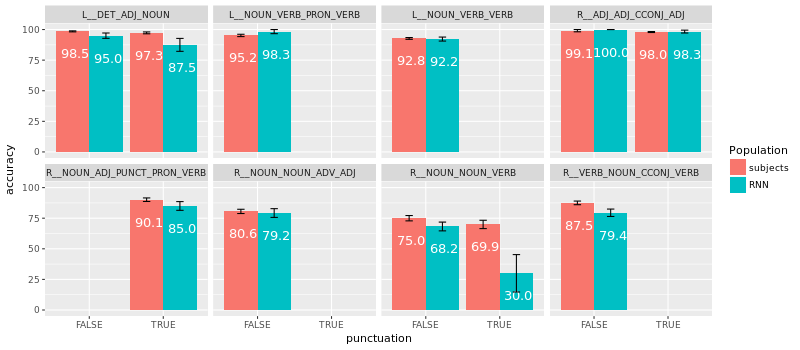

In [189]:
%%R -w 800 -h 350
dt = data.table(t)
#dt = dt[sent_id == 0]
x= dt[,.(LM=mean(get(best)),people=mean(mturk_count),
         se_lm=sd(get(best))/sqrt(.N),se_people=sd(mturk_count)/sqrt(.N)),by=.(punct,pattern)]
print(x)
#colnames(x) = c("punct","pattern","LM","people")
m = melt(x, idvars=c("punct"), measure.vars=c("people","LM"))
m$SE <- 0
m[variable == "people"]$SE <- m[variable == "people"]$se_people
m[variable == "LM"]$SE <- m[variable == "LM"]$se_lm

p = ggplot(m, aes(x=punct,y=value,fill=variable)) + geom_bar(stat="identity",position="dodge")  + facet_wrap(~pattern,ncol=4)
p = p + xlab("punctuation") + ylab("accuracy") + labs(fill="Population")
p = p + geom_text(aes(label=format(value, digits=3)), vjust=3, colour="white", position=position_dodge(.9), size=4.5) 
p + geom_errorbar(aes(ymin=value-SE, ymax=value+SE), width=.2,position=pd) + scale_fill_discrete(labels=c("subjects","RNN"))